In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [4]:
BATCH_SIZE = 2048
num_workers = 0

train_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split/chess_bitboard_train.npz"), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split/chess_bitboard_val.npz"), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split/chess_bitboard_test.npz"), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [5]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.02028674840927124


In [6]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 768]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [7]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [20]:
class DeepChessAutoencoder(nn.Module):
    """
    Step 1 of DeepChess Paper: Pos2Vec (The Autoencoder)
    We train this to compress the board (768) -> (256) -> reconstruct (768).
    This forces the model to learn 'what a chess board looks like' without worrying about who is winning.
    """
    def __init__(self, input_shape=768):
        super().__init__()
        
        # ENCODER (The part we will keep)
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 256), # Bottleneck
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        # DECODER (The part we throw away later)
        self.decoder = nn.Sequential(
            nn.Linear(256, 400),
            nn.ReLU(),
            nn.Linear(400, 600),
            nn.ReLU(),
            nn.Linear(600, input_shape),
            nn.Sigmoid() # Sigmoid because inputs are 0 or 1 (Bitboards)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_latent_features(self, x):
        return self.encoder(x)

In [30]:
class DeepChessBaseline(nn.Module):
    """
    DeepChess Architecture adapted for 7-class classification.
    
    Structure:
    1. Pos2Vec (Feature Extractor): Compresses the 768-bit board state into 100 features.
    2. Classifier Head: Maps the 100 features to the 7 class probabilities.
       Layers: 100 -> 100 -> Output(7)
    """
    def __init__(self, input_shape=768, output_shape=7):
        super().__init__()
        
        self.pos2vec = nn.Sequential(
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(400, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        features = self.pos2vec(x)
        logits = self.classifier(features)
        return logits


In [31]:
from torchinfo import summary

model = DeepChessBaseline(input_shape=768, output_shape=7)

summary(model, input_size=(2048, 768))

Layer (type:depth-idx)                   Output Shape              Param #
DeepChessBaseline                        [2048, 7]                 --
├─Sequential: 1-1                        [2048, 256]               --
│    └─Linear: 2-1                       [2048, 600]               461,400
│    └─BatchNorm1d: 2-2                  [2048, 600]               1,200
│    └─ReLU: 2-3                         [2048, 600]               --
│    └─Dropout: 2-4                      [2048, 600]               --
│    └─Linear: 2-5                       [2048, 400]               240,400
│    └─BatchNorm1d: 2-6                  [2048, 400]               800
│    └─ReLU: 2-7                         [2048, 400]               --
│    └─Dropout: 2-8                      [2048, 400]               --
│    └─Linear: 2-9                       [2048, 256]               102,656
│    └─BatchNorm1d: 2-10                 [2048, 256]               512
│    └─ReLU: 2-11                        [2048, 256]             

In [32]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [33]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [34]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"{model_save_name}.pth")
        else:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = DeepChessBaseline(input_shape=768,
                          output_shape=7).to(device)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001,
                             weight_decay=1e-4)

result = run_experiment(model=model,
                        model_save_name="deepchess_baseline",
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  1%|          | 1/100 [00:09<15:36,  9.46s/it]

Epoch 0: New Best Val Loss: 1.1706 (Saved)
Epoch: 0 | Train Loss: 1.0446287521620845 | Train Acc: 0.6168216012627877 | Val Loss: 1.1706276949571104 | Val Acc: 0.5630854862581824


  2%|▏         | 2/100 [00:19<15:46,  9.66s/it]

Epoch 1: Train Loss: 0.8395 | Val Loss: 1.2723
Epoch: 1 | Train Loss: 0.839536239119137 | Train Acc: 0.6801667898817136 | Val Loss: 1.272294509167574 | Val Acc: 0.5513095789613015


  3%|▎         | 3/100 [00:29<16:21, 10.12s/it]

Epoch 2: Train Loss: 0.7338 | Val Loss: 1.3088
Epoch: 2 | Train Loss: 0.7338271519107282 | Train Acc: 0.7211049892103581 | Val Loss: 1.308796374165282 | Val Acc: 0.5454735181218714


  4%|▍         | 4/100 [00:40<16:18, 10.19s/it]

Epoch 3: Train Loss: 0.6678 | Val Loss: 1.3728
Epoch: 3 | Train Loss: 0.6678199159824635 | Train Acc: 0.7471614749840153 | Val Loss: 1.3728138135404002 | Val Acc: 0.5478942424552368


  5%|▌         | 5/100 [00:50<16:11, 10.22s/it]

Epoch 4: Train Loss: 0.6234 | Val Loss: 1.4575
Epoch: 4 | Train Loss: 0.6234339442094574 | Train Acc: 0.7651791779891305 | Val Loss: 1.457466453922038 | Val Acc: 0.5463077514319407


  6%|▌         | 6/100 [01:00<16:08, 10.30s/it]

Epoch 5: Train Loss: 0.5891 | Val Loss: 1.4298
Epoch: 5 | Train Loss: 0.5891210746277323 | Train Acc: 0.7794007752557545 | Val Loss: 1.4297644970368366 | Val Acc: 0.549084016713997


  7%|▋         | 7/100 [01:11<16:10, 10.43s/it]

Epoch 6: Train Loss: 0.5635 | Val Loss: 1.4535
Epoch: 6 | Train Loss: 0.5635119893056962 | Train Acc: 0.7900235773657289 | Val Loss: 1.453452460619868 | Val Acc: 0.547386031358298


  8%|▊         | 8/100 [01:22<15:58, 10.42s/it]

Epoch 7: Train Loss: 0.5403 | Val Loss: 1.4867
Epoch: 7 | Train Loss: 0.5402986673290467 | Train Acc: 0.7993418817934783 | Val Loss: 1.4866768340675198 | Val Acc: 0.5458249226872353


  9%|▉         | 9/100 [01:32<15:40, 10.33s/it]

Epoch 8: Train Loss: 0.5237 | Val Loss: 1.5154
Epoch: 8 | Train Loss: 0.5237383991860978 | Train Acc: 0.8061096347506395 | Val Loss: 1.5154038910963097 | Val Acc: 0.5455944133254716


 10%|█         | 10/100 [01:42<15:40, 10.45s/it]

Epoch 9: Train Loss: 0.5091 | Val Loss: 1.5241
Epoch: 9 | Train Loss: 0.5091418424988037 | Train Acc: 0.8117432265025576 | Val Loss: 1.5241344948204196 | Val Acc: 0.545352998953119


 11%|█         | 11/100 [01:53<15:31, 10.46s/it]

Epoch 10: Train Loss: 0.4968 | Val Loss: 1.5463
Epoch: 10 | Train Loss: 0.49682016095237047 | Train Acc: 0.8170356457800512 | Val Loss: 1.5462599116928724 | Val Acc: 0.5435784905058721


 12%|█▏        | 12/100 [02:03<15:14, 10.39s/it]

Epoch 11: Train Loss: 0.4866 | Val Loss: 1.5339
Epoch: 11 | Train Loss: 0.48658271777965223 | Train Acc: 0.8208692155530691 | Val Loss: 1.5338695487197564 | Val Acc: 0.5436486210050058


 13%|█▎        | 13/100 [02:12<14:23,  9.93s/it]

Epoch 12: Train Loss: 0.4772 | Val Loss: 1.5628
Epoch: 12 | Train Loss: 0.47723316902394797 | Train Acc: 0.8247924492487213 | Val Loss: 1.5628151942272575 | Val Acc: 0.5409877984212553


 14%|█▍        | 14/100 [02:22<14:16,  9.96s/it]

Epoch 13: Train Loss: 0.4694 | Val Loss: 1.5851
Epoch: 13 | Train Loss: 0.46943124549468157 | Train Acc: 0.8269850943094629 | Val Loss: 1.585071483436896 | Val Acc: 0.5412184958004428


 15%|█▌        | 15/100 [02:31<13:36,  9.61s/it]

Epoch 14: Train Loss: 0.4618 | Val Loss: 1.5786
Epoch: 14 | Train Loss: 0.4618255371785225 | Train Acc: 0.8305491727941176 | Val Loss: 1.578639030456543 | Val Acc: 0.5403425226222565


 16%|█▌        | 16/100 [02:40<13:10,  9.41s/it]

Epoch 15: Train Loss: 0.4573 | Val Loss: 1.5849
Epoch: 15 | Train Loss: 0.4573056487476124 | Train Acc: 0.8321448909047314 | Val Loss: 1.5848781648947268 | Val Acc: 0.5406548195634385


 17%|█▋        | 17/100 [02:49<12:47,  9.24s/it]

Epoch 16: Train Loss: 0.4511 | Val Loss: 1.6057
Epoch: 16 | Train Loss: 0.4510542705388325 | Train Acc: 0.8347271619245525 | Val Loss: 1.605709187838496 | Val Acc: 0.5441214848262418


 18%|█▊        | 18/100 [02:58<12:34,  9.20s/it]

Epoch 17: Train Loss: 0.4465 | Val Loss: 1.6231
Epoch: 17 | Train Loss: 0.44647496168875633 | Train Acc: 0.8368441296355499 | Val Loss: 1.6231278205404476 | Val Acc: 0.5411895411171544


 19%|█▉        | 19/100 [03:07<12:27,  9.23s/it]

Epoch 18: Train Loss: 0.4415 | Val Loss: 1.5909
Epoch: 18 | Train Loss: 0.44153820485105294 | Train Acc: 0.838196081761509 | Val Loss: 1.5908798392938108 | Val Acc: 0.5467774189569696


 20%|██        | 20/100 [03:17<12:26,  9.33s/it]

Epoch 19: Train Loss: 0.4370 | Val Loss: 1.6164
Epoch: 19 | Train Loss: 0.4369826611045681 | Train Acc: 0.8404818873881074 | Val Loss: 1.6164110825986278 | Val Acc: 0.5452249590874085


 21%|██        | 21/100 [03:26<12:20,  9.38s/it]

Epoch 20: Train Loss: 0.4344 | Val Loss: 1.6270
Epoch: 20 | Train Loss: 0.43441616574211805 | Train Acc: 0.8416315337276215 | Val Loss: 1.6269987018740908 | Val Acc: 0.5462667636335194


 22%|██▏       | 22/100 [03:35<12:03,  9.28s/it]

Epoch 21: Train Loss: 0.4310 | Val Loss: 1.6045
Epoch: 21 | Train Loss: 0.43104385818971697 | Train Acc: 0.8424477501598465 | Val Loss: 1.6044682191342723 | Val Acc: 0.5397310899595688


 23%|██▎       | 23/100 [03:44<11:54,  9.28s/it]

Epoch 22: Train Loss: 0.4288 | Val Loss: 1.6155
Epoch: 22 | Train Loss: 0.42881856268019325 | Train Acc: 0.8436555906329923 | Val Loss: 1.6155029048725051 | Val Acc: 0.5441233650004813


 24%|██▍       | 24/100 [03:54<11:48,  9.33s/it]

Epoch 23: Train Loss: 0.4242 | Val Loss: 1.6282
Epoch: 23 | Train Loss: 0.4242111956676864 | Train Acc: 0.8455425291719949 | Val Loss: 1.6281729717643894 | Val Acc: 0.5427147384602427


 25%|██▌       | 25/100 [04:03<11:42,  9.37s/it]

Epoch 24: Train Loss: 0.4218 | Val Loss: 1.6372
Epoch: 24 | Train Loss: 0.4218175884555368 | Train Acc: 0.8466721946930946 | Val Loss: 1.6371769223894392 | Val Acc: 0.5428651523994031


 26%|██▌       | 26/100 [04:12<11:21,  9.21s/it]

Epoch 25: Train Loss: 0.4199 | Val Loss: 1.6353
Epoch: 25 | Train Loss: 0.4199016353358393 | Train Acc: 0.8472883531809463 | Val Loss: 1.6353060299036455 | Val Acc: 0.5366066164083557


 27%|██▋       | 27/100 [04:22<11:35,  9.53s/it]

Epoch 26: Train Loss: 0.4181 | Val Loss: 1.6353
Epoch: 26 | Train Loss: 0.41807480952928744 | Train Acc: 0.8477571531329924 | Val Loss: 1.6353160653795515 | Val Acc: 0.5390487747280516


 28%|██▊       | 28/100 [04:33<11:38,  9.69s/it]

Epoch 27: Train Loss: 0.4145 | Val Loss: 1.6512
Epoch: 27 | Train Loss: 0.41452800648291704 | Train Acc: 0.8491143502237851 | Val Loss: 1.651245438322729 | Val Acc: 0.5412401178041971


 29%|██▉       | 29/100 [04:42<11:31,  9.74s/it]

Epoch 28: Train Loss: 0.4148 | Val Loss: 1.6389
Epoch: 28 | Train Loss: 0.41483296549228754 | Train Acc: 0.8493096627237852 | Val Loss: 1.6388931177100357 | Val Acc: 0.5435957881088757


 30%|███       | 30/100 [04:53<11:30,  9.86s/it]

Epoch 29: Train Loss: 0.4106 | Val Loss: 1.6566
Epoch: 29 | Train Loss: 0.41064140475009714 | Train Acc: 0.8507710098305626 | Val Loss: 1.6565813093769306 | Val Acc: 0.5418321846722179


 31%|███       | 31/100 [05:03<11:40, 10.16s/it]

Epoch 30: Train Loss: 0.4100 | Val Loss: 1.6553
Epoch: 30 | Train Loss: 0.4100450053239417 | Train Acc: 0.8506483775575447 | Val Loss: 1.6552949073363323 | Val Acc: 0.5428839541417982


 32%|███▏      | 32/100 [05:15<11:51, 10.46s/it]

Epoch 31: Train Loss: 0.4082 | Val Loss: 1.6522
Epoch: 31 | Train Loss: 0.4081823670345804 | Train Acc: 0.8517036145300512 | Val Loss: 1.6522339850055927 | Val Acc: 0.53958124007268


 33%|███▎      | 33/100 [05:25<11:37, 10.40s/it]

Epoch 32: Train Loss: 0.4075 | Val Loss: 1.6954
Epoch: 32 | Train Loss: 0.4074667547364979 | Train Acc: 0.8522048833120205 | Val Loss: 1.6954285392955857 | Val Acc: 0.5396720524884482


 34%|███▍      | 34/100 [05:34<11:09, 10.14s/it]

Epoch 33: Train Loss: 0.4043 | Val Loss: 1.6498
Epoch: 33 | Train Loss: 0.40434130607053753 | Train Acc: 0.8524603880274936 | Val Loss: 1.6498281396165186 | Val Acc: 0.5416815827156335


 35%|███▌      | 35/100 [05:44<10:51, 10.03s/it]

Epoch 34: Train Loss: 0.4029 | Val Loss: 1.6736
Epoch: 34 | Train Loss: 0.4029003066175124 | Train Acc: 0.8535690736892584 | Val Loss: 1.6735886992240439 | Val Acc: 0.5384662967486523


 36%|███▌      | 36/100 [05:54<10:37,  9.96s/it]

Epoch 35: Train Loss: 0.4022 | Val Loss: 1.6779
Epoch: 35 | Train Loss: 0.4022417000644957 | Train Acc: 0.8538395640185422 | Val Loss: 1.6778991295366872 | Val Acc: 0.5413771825062572


 37%|███▋      | 37/100 [06:03<10:14,  9.75s/it]

Epoch 36: Train Loss: 0.4009 | Val Loss: 1.6571
Epoch: 36 | Train Loss: 0.400933922251777 | Train Acc: 0.8540099004955244 | Val Loss: 1.6571001690261218 | Val Acc: 0.5421450456656719


 38%|███▊      | 38/100 [06:13<10:09,  9.82s/it]

Epoch 37: Train Loss: 0.3989 | Val Loss: 1.6359
Epoch: 37 | Train Loss: 0.3988926051675206 | Train Acc: 0.8553898257672635 | Val Loss: 1.63591426002736 | Val Acc: 0.5388295464117251


 39%|███▉      | 39/100 [06:23<10:04,  9.90s/it]

Epoch 38: Train Loss: 0.3980 | Val Loss: 1.6793
Epoch: 38 | Train Loss: 0.39799474976251803 | Train Acc: 0.8557934382992327 | Val Loss: 1.6792675208072274 | Val Acc: 0.5426993210314786


 40%|████      | 40/100 [06:33<09:53,  9.90s/it]

Epoch 39: Train Loss: 0.3967 | Val Loss: 1.6907
Epoch: 39 | Train Loss: 0.3966636831498207 | Train Acc: 0.8553670975863171 | Val Loss: 1.6906615665980749 | Val Acc: 0.5449325919931651


 41%|████      | 41/100 [06:43<09:36,  9.77s/it]

Epoch 40: Train Loss: 0.3957 | Val Loss: 1.6638
Epoch: 40 | Train Loss: 0.3956937809734393 | Train Acc: 0.8566019121643222 | Val Loss: 1.6638221035198288 | Val Acc: 0.5439291430015403


 42%|████▏     | 42/100 [06:53<09:29,  9.82s/it]

Epoch 41: Train Loss: 0.3942 | Val Loss: 1.6913
Epoch: 41 | Train Loss: 0.3941661733800493 | Train Acc: 0.8563791260390026 | Val Loss: 1.691277068488452 | Val Acc: 0.5457019592919715


 43%|████▎     | 43/100 [07:02<09:15,  9.74s/it]

Epoch 42: Train Loss: 0.3935 | Val Loss: 1.6706
Epoch: 42 | Train Loss: 0.3935394175827046 | Train Acc: 0.8570272538363172 | Val Loss: 1.6706024116399336 | Val Acc: 0.5442326031237967


 44%|████▍     | 44/100 [07:12<09:03,  9.70s/it]

Epoch 43: Train Loss: 0.3920 | Val Loss: 1.6822
Epoch: 43 | Train Loss: 0.39200138237775134 | Train Acc: 0.8579463714833759 | Val Loss: 1.6822038596990156 | Val Acc: 0.5385078485993454


 45%|████▌     | 45/100 [07:21<08:47,  9.60s/it]

Epoch 44: Train Loss: 0.3909 | Val Loss: 1.6791
Epoch: 44 | Train Loss: 0.3909459205539635 | Train Acc: 0.8578926730338875 | Val Loss: 1.6791155654556897 | Val Acc: 0.5440680878778398


 46%|████▌     | 46/100 [07:30<08:32,  9.48s/it]

Epoch 45: Train Loss: 0.3911 | Val Loss: 1.6888
Epoch: 45 | Train Loss: 0.39110468522362085 | Train Acc: 0.8580222985933504 | Val Loss: 1.6887801958590138 | Val Acc: 0.5430527937885059


 47%|████▋     | 47/100 [07:39<08:16,  9.36s/it]

Epoch 46: Train Loss: 0.3899 | Val Loss: 1.7100
Epoch: 46 | Train Loss: 0.3898705060372267 | Train Acc: 0.8587598405530691 | Val Loss: 1.710049456479598 | Val Acc: 0.5410656376347709


 48%|████▊     | 48/100 [07:48<08:03,  9.30s/it]

Epoch 47: Train Loss: 0.3884 | Val Loss: 1.6683
Epoch: 47 | Train Loss: 0.3883641446795305 | Train Acc: 0.8591756913363172 | Val Loss: 1.6682981885209376 | Val Acc: 0.53709414558866


 49%|████▉     | 49/100 [07:58<07:55,  9.32s/it]

Epoch 48: Train Loss: 0.3887 | Val Loss: 1.6965
Epoch: 48 | Train Loss: 0.3886690069647396 | Train Acc: 0.858963395140665 | Val Loss: 1.6965444988133955 | Val Acc: 0.5418600112509626


 50%|█████     | 50/100 [08:07<07:42,  9.25s/it]

Epoch 49: Train Loss: 0.3889 | Val Loss: 1.6627
Epoch: 49 | Train Loss: 0.3888549518097392 | Train Acc: 0.8589231837436061 | Val Loss: 1.6626919775593036 | Val Acc: 0.5385994130848094


 51%|█████     | 51/100 [08:17<07:44,  9.48s/it]

Epoch 50: Train Loss: 0.3872 | Val Loss: 1.7042
Epoch: 50 | Train Loss: 0.3872011970071232 | Train Acc: 0.8598273157768541 | Val Loss: 1.704159639319595 | Val Acc: 0.5438373904986523


 52%|█████▏    | 52/100 [08:26<07:33,  9.45s/it]

Epoch 51: Train Loss: 0.3852 | Val Loss: 1.7043
Epoch: 51 | Train Loss: 0.3851800440522411 | Train Acc: 0.8602698909047314 | Val Loss: 1.7042655969152645 | Val Acc: 0.5389015570850981


 53%|█████▎    | 53/100 [08:36<07:26,  9.49s/it]

Epoch 52: Train Loss: 0.3854 | Val Loss: 1.7142
Epoch: 52 | Train Loss: 0.38540516195394803 | Train Acc: 0.8598095828005116 | Val Loss: 1.7141728814767332 | Val Acc: 0.5402426853701386


 54%|█████▍    | 54/100 [08:45<07:15,  9.48s/it]

Epoch 53: Train Loss: 0.3853 | Val Loss: 1.6842
Epoch: 53 | Train Loss: 0.3852768711116918 | Train Acc: 0.8599661824648338 | Val Loss: 1.6841650228111111 | Val Acc: 0.5389427329009434


 55%|█████▌    | 55/100 [08:55<07:06,  9.47s/it]

Epoch 54: Train Loss: 0.3834 | Val Loss: 1.7017
Epoch: 54 | Train Loss: 0.3834296988556757 | Train Acc: 0.8605671055786445 | Val Loss: 1.7016935397167594 | Val Acc: 0.5438513037880247


 56%|█████▌    | 56/100 [09:04<06:55,  9.44s/it]

Epoch 55: Train Loss: 0.3834 | Val Loss: 1.7022
Epoch: 55 | Train Loss: 0.3833641488381359 | Train Acc: 0.8603545596227622 | Val Loss: 1.7022426104059025 | Val Acc: 0.5413566886070466


 57%|█████▋    | 57/100 [09:14<06:45,  9.43s/it]

Epoch 56: Train Loss: 0.3819 | Val Loss: 1.7033
Epoch: 56 | Train Loss: 0.38189241236737925 | Train Acc: 0.8615002097985934 | Val Loss: 1.7033415838163726 | Val Acc: 0.5441767619488833


 58%|█████▊    | 58/100 [09:23<06:38,  9.50s/it]

Epoch 57: Train Loss: 0.3824 | Val Loss: 1.6756
Epoch: 57 | Train Loss: 0.3823688646868976 | Train Acc: 0.8615931206042199 | Val Loss: 1.6755744486438984 | Val Acc: 0.5411652868694647


 59%|█████▉    | 59/100 [09:33<06:32,  9.56s/it]

Epoch 58: Train Loss: 0.3805 | Val Loss: 1.7024
Epoch: 58 | Train Loss: 0.3805492101118083 | Train Acc: 0.8620139665920715 | Val Loss: 1.7023960716870365 | Val Acc: 0.5443187151039661


 60%|██████    | 60/100 [09:44<06:34,  9.87s/it]

Epoch 59: Train Loss: 0.3811 | Val Loss: 1.7071
Epoch: 59 | Train Loss: 0.3811401837622113 | Train Acc: 0.8620167139546037 | Val Loss: 1.7070766906349026 | Val Acc: 0.5434916264560069


 61%|██████    | 61/100 [09:53<06:23,  9.84s/it]

Epoch 60: Train Loss: 0.3796 | Val Loss: 1.7259
Epoch: 60 | Train Loss: 0.3796179923407562 | Train Acc: 0.8624423053868285 | Val Loss: 1.725861162555461 | Val Acc: 0.5395054690508279


 62%|██████▏   | 62/100 [10:03<06:12,  9.80s/it]

Epoch 61: Train Loss: 0.3798 | Val Loss: 1.6733
Epoch: 61 | Train Loss: 0.3798242965927514 | Train Acc: 0.8623056865409208 | Val Loss: 1.6733092653508088 | Val Acc: 0.5405380607431651


 63%|██████▎   | 63/100 [10:13<06:07,  9.93s/it]

Epoch 62: Train Loss: 0.3785 | Val Loss: 1.6766
Epoch: 62 | Train Loss: 0.3785435584804896 | Train Acc: 0.8626978101023018 | Val Loss: 1.6766149170544682 | Val Acc: 0.5382495126588371


 64%|██████▍   | 64/100 [10:23<05:58,  9.95s/it]

Epoch 63: Train Loss: 0.3775 | Val Loss: 1.6867
Epoch: 63 | Train Loss: 0.37749101728429574 | Train Acc: 0.8631039202365729 | Val Loss: 1.686735148332557 | Val Acc: 0.5369441076843473


 65%|██████▌   | 65/100 [10:33<05:50, 10.01s/it]

Epoch 64: Train Loss: 0.3782 | Val Loss: 1.6883
Epoch: 64 | Train Loss: 0.3781734028130846 | Train Acc: 0.8630519701086957 | Val Loss: 1.6882814217586906 | Val Acc: 0.5415283485151137


 66%|██████▌   | 66/100 [10:42<05:29,  9.70s/it]

Epoch 65: Train Loss: 0.3775 | Val Loss: 1.6995
Epoch: 65 | Train Loss: 0.3775213347828906 | Train Acc: 0.8629360813618926 | Val Loss: 1.6995120413449345 | Val Acc: 0.5381066194166345


 67%|██████▋   | 67/100 [10:52<05:23,  9.79s/it]

Epoch 66: Train Loss: 0.3776 | Val Loss: 1.6917
Epoch: 66 | Train Loss: 0.37756618346704546 | Train Acc: 0.8628476662404093 | Val Loss: 1.691688914688266 | Val Acc: 0.5400514716499808


 68%|██████▊   | 68/100 [11:02<05:14,  9.84s/it]

Epoch 67: Train Loss: 0.3770 | Val Loss: 1.6860
Epoch: 67 | Train Loss: 0.3769809344540472 | Train Acc: 0.8632949868126598 | Val Loss: 1.6859922141444927 | Val Acc: 0.5417569777026376


 69%|██████▉   | 69/100 [11:11<04:52,  9.43s/it]

Epoch 68: Train Loss: 0.3773 | Val Loss: 1.7223
Epoch: 68 | Train Loss: 0.377323901180721 | Train Acc: 0.8632535266144502 | Val Loss: 1.7223227461990045 | Val Acc: 0.541568584243839


 70%|███████   | 70/100 [11:20<04:44,  9.49s/it]

Epoch 69: Train Loss: 0.3755 | Val Loss: 1.6854
Epoch: 69 | Train Loss: 0.3754706587785345 | Train Acc: 0.86343485254156 | Val Loss: 1.6854097794513314 | Val Acc: 0.5397265775413939


 71%|███████   | 71/100 [11:30<04:33,  9.44s/it]

Epoch 70: Train Loss: 0.3749 | Val Loss: 1.7142
Epoch: 70 | Train Loss: 0.3749298370250351 | Train Acc: 0.8638661884590794 | Val Loss: 1.714217151914324 | Val Acc: 0.5410502202060069


 72%|███████▏  | 72/100 [11:40<04:31,  9.71s/it]

Epoch 71: Train Loss: 0.3738 | Val Loss: 1.7019
Epoch: 71 | Train Loss: 0.37381944548138574 | Train Acc: 0.8646479379795396 | Val Loss: 1.7019191931705087 | Val Acc: 0.5413403310911629


 73%|███████▎  | 73/100 [11:50<04:20,  9.66s/it]

Epoch 72: Train Loss: 0.3742 | Val Loss: 1.7386
Epoch: 72 | Train Loss: 0.3742099612417733 | Train Acc: 0.8646726642423274 | Val Loss: 1.7385818860968765 | Val Acc: 0.541011864651521


 74%|███████▍  | 74/100 [12:00<04:15,  9.82s/it]

Epoch 73: Train Loss: 0.3740 | Val Loss: 1.7040
Epoch: 73 | Train Loss: 0.37404321846754657 | Train Acc: 0.8648120304507673 | Val Loss: 1.7040442082346703 | Val Acc: 0.5373842564738159


 75%|███████▌  | 75/100 [12:10<04:11, 10.04s/it]

Epoch 74: Train Loss: 0.3729 | Val Loss: 1.7098
Epoch: 74 | Train Loss: 0.37294773410653215 | Train Acc: 0.8653030590632992 | Val Loss: 1.709805418033989 | Val Acc: 0.5408578783813054


 76%|███████▌  | 76/100 [12:20<04:00, 10.01s/it]

Epoch 75: Train Loss: 0.3739 | Val Loss: 1.6993
Epoch: 75 | Train Loss: 0.37388717579414776 | Train Acc: 0.8647420975863171 | Val Loss: 1.6993117819027024 | Val Acc: 0.5406012345976127


 77%|███████▋  | 77/100 [12:30<03:47,  9.88s/it]

Epoch 76: Train Loss: 0.3725 | Val Loss: 1.7119
Epoch: 76 | Train Loss: 0.3724992338501279 | Train Acc: 0.8652643462276215 | Val Loss: 1.7118558932323844 | Val Acc: 0.5416054356589334


 78%|███████▊  | 78/100 [12:39<03:35,  9.77s/it]

Epoch 77: Train Loss: 0.3727 | Val Loss: 1.7127
Epoch: 77 | Train Loss: 0.37267332918503704 | Train Acc: 0.8649356617647059 | Val Loss: 1.7127040405662692 | Val Acc: 0.5401795115156912


 79%|███████▉  | 79/100 [12:49<03:23,  9.69s/it]

Epoch 78: Train Loss: 0.3725 | Val Loss: 1.6739
Epoch: 78 | Train Loss: 0.3725153098021017 | Train Acc: 0.8650213295236573 | Val Loss: 1.6739039494066823 | Val Acc: 0.5361847053090104


 80%|████████  | 80/100 [12:58<03:12,  9.61s/it]

Epoch 79: Train Loss: 0.3708 | Val Loss: 1.6994
Epoch: 79 | Train Loss: 0.37084850036274747 | Train Acc: 0.865901234814578 | Val Loss: 1.6993918686496967 | Val Acc: 0.5409520751107046


 81%|████████  | 81/100 [13:08<03:05,  9.74s/it]

Epoch 80: Train Loss: 0.3704 | Val Loss: 1.6983
Epoch: 80 | Train Loss: 0.37038839877109087 | Train Acc: 0.8657898417519182 | Val Loss: 1.698342457109568 | Val Acc: 0.5383897736571043


 82%|████████▏ | 82/100 [13:18<02:55,  9.76s/it]

Epoch 81: Train Loss: 0.3700 | Val Loss: 1.7232
Epoch: 81 | Train Loss: 0.36995094381939725 | Train Acc: 0.8657164122442456 | Val Loss: 1.7231583911545423 | Val Acc: 0.5417957092919715


 83%|████████▎ | 83/100 [13:28<02:47,  9.85s/it]

Epoch 82: Train Loss: 0.3694 | Val Loss: 1.7075
Epoch: 82 | Train Loss: 0.3694358005395631 | Train Acc: 0.8658785066336318 | Val Loss: 1.7074550195616118 | Val Acc: 0.5358968506329419


 84%|████████▍ | 84/100 [13:37<02:32,  9.56s/it]

Epoch 83: Train Loss: 0.3696 | Val Loss: 1.7121
Epoch: 83 | Train Loss: 0.3695964988540201 | Train Acc: 0.8662396599264706 | Val Loss: 1.7120513599746081 | Val Acc: 0.5386719878104543


 85%|████████▌ | 85/100 [13:47<02:24,  9.64s/it]

Epoch 84: Train Loss: 0.3691 | Val Loss: 1.7341
Epoch: 84 | Train Loss: 0.3690814609875155 | Train Acc: 0.8664789302269821 | Val Loss: 1.734145972193504 | Val Acc: 0.5398209622882172


 86%|████████▌ | 86/100 [13:56<02:13,  9.56s/it]

Epoch 85: Train Loss: 0.3682 | Val Loss: 1.7175
Epoch: 85 | Train Loss: 0.3682197136494815 | Train Acc: 0.8662863650895141 | Val Loss: 1.7174742659743951 | Val Acc: 0.5394783945417789


 87%|████████▋ | 87/100 [14:06<02:06,  9.73s/it]

Epoch 86: Train Loss: 0.3684 | Val Loss: 1.7186
Epoch: 86 | Train Loss: 0.36841782660740413 | Train Acc: 0.8665720907928388 | Val Loss: 1.7186137389163583 | Val Acc: 0.5380195673493454


 88%|████████▊ | 88/100 [14:16<01:55,  9.63s/it]

Epoch 87: Train Loss: 0.3673 | Val Loss: 1.7153
Epoch: 87 | Train Loss: 0.367281919550103 | Train Acc: 0.866805366847826 | Val Loss: 1.715263228027188 | Val Acc: 0.5424289519758375


 89%|████████▉ | 89/100 [14:26<01:47,  9.78s/it]

Epoch 88: Train Loss: 0.3681 | Val Loss: 1.7337
Epoch: 88 | Train Loss: 0.368100938437235 | Train Acc: 0.8666118026694374 | Val Loss: 1.7336898433918855 | Val Acc: 0.541122606914228


 90%|█████████ | 90/100 [14:36<01:38,  9.84s/it]

Epoch 89: Train Loss: 0.3676 | Val Loss: 1.7121
Epoch: 89 | Train Loss: 0.3676344608254445 | Train Acc: 0.8670566256393861 | Val Loss: 1.7120797682781608 | Val Acc: 0.54022990018531


 91%|█████████ | 91/100 [14:46<01:29,  9.97s/it]

Epoch 90: Train Loss: 0.3680 | Val Loss: 1.6949
Epoch: 90 | Train Loss: 0.3680455412553704 | Train Acc: 0.8669951846227621 | Val Loss: 1.6948885990648854 | Val Acc: 0.5390525350765306


 92%|█████████▏| 92/100 [14:56<01:20, 10.01s/it]

Epoch 91: Train Loss: 0.3667 | Val Loss: 1.6934
Epoch: 91 | Train Loss: 0.3667478582743184 | Train Acc: 0.8671075767263428 | Val Loss: 1.6933966169551926 | Val Acc: 0.5400954677271852


 93%|█████████▎| 93/100 [15:06<01:09,  9.97s/it]

Epoch 92: Train Loss: 0.3669 | Val Loss: 1.7167
Epoch: 92 | Train Loss: 0.3669140514205484 | Train Acc: 0.8666625039961636 | Val Loss: 1.7167320932660783 | Val Acc: 0.540725514114844


 94%|█████████▍| 94/100 [15:17<01:01, 10.29s/it]

Epoch 93: Train Loss: 0.3668 | Val Loss: 1.7331
Epoch: 93 | Train Loss: 0.3667623335900514 | Train Acc: 0.8674709778612532 | Val Loss: 1.733092797045805 | Val Acc: 0.5370170584448402


 95%|█████████▌| 95/100 [15:28<00:52, 10.41s/it]

Epoch 94: Train Loss: 0.3669 | Val Loss: 1.7159
Epoch: 94 | Train Loss: 0.3668504178219134 | Train Acc: 0.8669527253836317 | Val Loss: 1.715891001175861 | Val Acc: 0.5404733827493261


 96%|█████████▌| 96/100 [15:39<00:41, 10.49s/it]

Epoch 95: Train Loss: 0.3654 | Val Loss: 1.6924
Epoch: 95 | Train Loss: 0.3653702451597394 | Train Acc: 0.8677729379795397 | Val Loss: 1.6923640236562612 | Val Acc: 0.5388195814882557


 97%|█████████▋| 97/100 [15:48<00:30, 10.04s/it]

Epoch 96: Train Loss: 0.3656 | Val Loss: 1.7028
Epoch: 96 | Train Loss: 0.3656002006414906 | Train Acc: 0.8678516124520461 | Val Loss: 1.7028416760113774 | Val Acc: 0.5406738093232576


 98%|█████████▊| 98/100 [15:58<00:20, 10.01s/it]

Epoch 97: Train Loss: 0.3655 | Val Loss: 1.7360
Epoch: 97 | Train Loss: 0.36554727491820255 | Train Acc: 0.8676048493446291 | Val Loss: 1.7359676774667234 | Val Acc: 0.5399941263356758


 99%|█████████▉| 99/100 [16:08<00:10, 10.25s/it]

Epoch 98: Train Loss: 0.3647 | Val Loss: 1.7451
Epoch: 98 | Train Loss: 0.36471986252328625 | Train Acc: 0.8680991248401535 | Val Loss: 1.7451452819668516 | Val Acc: 0.5419557121197536


100%|██████████| 100/100 [16:19<00:00,  9.79s/it]

Epoch 99: Train Loss: 0.3642 | Val Loss: 1.7275
Epoch: 99 | Train Loss: 0.364204777781006 | Train Acc: 0.8680986253196931 | Val Loss: 1.727519120488848 | Val Acc: 0.5406676047482672

Loaded best model weights with Val Loss: 1.1706


In [36]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [37]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Convert a FEN string into a 768-length binary vector.
    Each of the 12 piece types has its own 64-slot block, one per square. 
    A 1 marks the presence of a piece on a square, 0 otherwise.
    """

    board = chess.Board(fen)
    vector = np.zeros(64*12, dtype=np.uint8)

    for square, piece in board.piece_map().items():
        idx = 64*piece_to_index[piece.symbol()] + square
        vector[idx] = 1
    return vector

In [38]:
def fen_to_vector_with_state(fen: str, is_check: bool) -> np.ndarray:
    """
    Converts FEN to a 775-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(775, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0

    # Is there a check?
    vector[774] = 1.0 if is_check else 0.0
    
    return vector

Model Prediction:  3
Stockfish Evaluation:  5


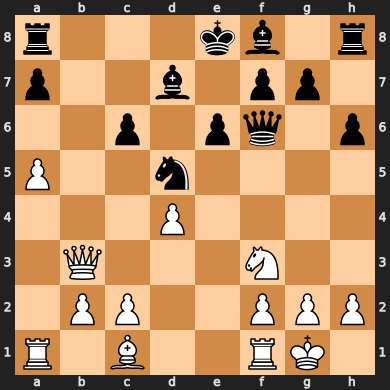

In [39]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [40]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.44      0.34      0.39      6062
           1       0.25      0.17      0.20      7513
           2       0.40      0.17      0.24     15196
           3       0.63      0.88      0.74     53898
           4       0.29      0.12      0.17      7618
           5       0.28      0.12      0.17      5290
           6       0.41      0.33      0.36      4423

    accuracy                           0.56    100000
   macro avg       0.39      0.30      0.32    100000
weighted avg       0.50      0.56      0.51    100000



In [41]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")


In [42]:
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [43]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)

In [44]:
RUN_ID = "run_2025_12_28_deepchess_baseline"

hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "input_shape": 768,
    "output_shape": 7,
    "weight_decay": 0.0001
}

dataset_paths = {
    "train": "./dataset_processed_clean_split/chess_bitboard_train.npz",
    "val":   "./dataset_processed_clean_split/chess_bitboard_val.npz",
    "test":  "./dataset_processed_clean_split/chess_bitboard_test.npz"
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2025_12_28_deepchess_baseline_config.json
[Logs] Saved training history to experiments/logs/run_2025_12_28_deepchess_baseline_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        54.73%
[Results] Off-by-1 Acc:    80.33%
[Results] MAE:             0.7661
[Results] Latency:         0.0093 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 7324 samples
   - Off by 4: 679 samples
   - Off by 5: 482 samples
   - Off by 6: 389 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


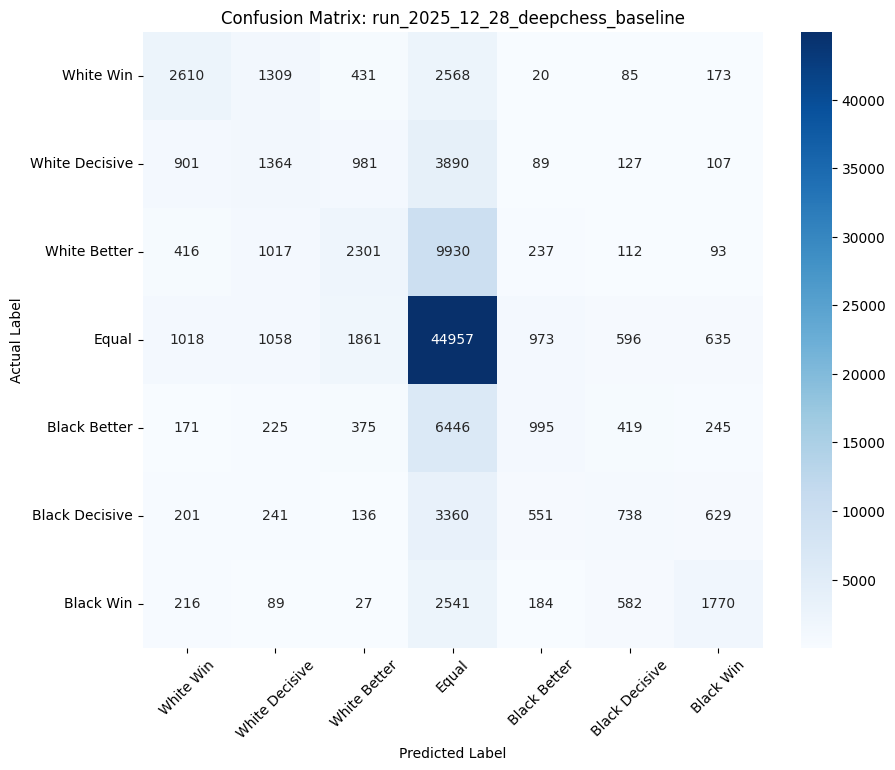

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

plot_confusion_matrix(RUN_ID)